In [1]:
# Data sets + training parameters

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler

train_dir = './train_images'
test_dir = './test_images'

transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2
batch_size = 32
CLASSIFIER_SIZE = 36

num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:
# Data loaders

train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

kwargs = {'pin_memory': True} if device=='cuda' else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1, **kwargs)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1, **kwargs)
classes = ('noface','face')



In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(36*36, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = x.reshape((-1, 36*36))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# NN creation 
# initialisation of optimiser

net = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



In [6]:
# Training of classifier

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 0.620
[1,   400] loss: 0.600
[1,   600] loss: 0.608
[1,   800] loss: 0.594
[1,  1000] loss: 0.609
[1,  1200] loss: 0.595
[1,  1400] loss: 0.585
[1,  1600] loss: 0.559
[1,  1800] loss: 0.483
[1,  2000] loss: 0.356
[1,  2200] loss: 0.285
[2,   200] loss: 0.242
[2,   400] loss: 0.222
[2,   600] loss: 0.208
[2,   800] loss: 0.195
[2,  1000] loss: 0.189
[2,  1200] loss: 0.167
[2,  1400] loss: 0.161
[2,  1600] loss: 0.159
[2,  1800] loss: 0.147
[2,  2000] loss: 0.145
[2,  2200] loss: 0.154
[3,   200] loss: 0.127
[3,   400] loss: 0.135
[3,   600] loss: 0.121
[3,   800] loss: 0.118
[3,  1000] loss: 0.116
[3,  1200] loss: 0.109
[3,  1400] loss: 0.109
[3,  1600] loss: 0.108
[3,  1800] loss: 0.103
[3,  2000] loss: 0.093
[3,  2200] loss: 0.093
Finished Training


In [138]:
# Test of classifier

correct = 0
correct_face = 0
correct_nonface = 0
total = 0
total_nonface = 0
total_face = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total_nonface += (labels == 0).sum().item()
        total_face += (labels == 1).sum().item()
        correct += (predicted == labels).sum().item()
        correct_nonface += ((predicted == labels) & (labels==0)).sum().item()
        correct_face    += ((predicted == labels) & (labels==1)).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))
print("Correct non-faces: %d/%d  %d %%" % (correct_nonface, total_nonface, 100*correct_nonface / total_nonface))
print("Correct     faces: %d/%d  %d %%" % (correct_face, total_face, 100*correct_face / total_face))


Accuracy of the network on the 7628 test images: 90 %
Correct non-faces: 6773/6831  99 %
Correct     faces: 163/797  20 %


In [ ]:
# Sauvegarder et charger un modèle
# uniquement les poids/paramètres :
torch.save(net.state_dict(), 'model_weights.pth')
model.load_state_dict(torch.load('model_weights.pth'))

# Les paramètres avec l'architecture :
torch.save(model, 'model.pth')
model = torch.load('model.pth')




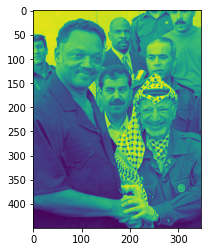

In [88]:
import cv2
import matplotlib.pyplot as plt

testimg = cv2.imread("./img_833.jpg")
gray = cv2.cvtColor(testimg, cv2.COLOR_BGR2GRAY).astype(float)
gray = gray/128.0 - 1.0
plt.imshow(gray)
plt.show()